# Customer Churn Prediction — Bank Dataset

**Author:** Hamza Shahid  
**Goal:** Predict which customers will churn (Exited = 1) so the bank can target retention campaigns and reduce customer acquisition costs.  
**Dataset:** `Churn_Modelling.csv` (Kaggle / archive) — customer demographics, account info, activity signals.  
**Approach overview:**  
1. Exploratory Data Analysis to understand churn drivers.  
2. Feature engineering and scaling.  
3. Compare classical models (Logistic Regression, Random Forest / XGBoost) with a Keras ANN.  
4. Use interpretation (feature importance, SHAP) to produce actionable business recommendations.  
5. Deliverables: evaluation metrics, business insights, short "who to target" playbook, and a lightweight demo (model saved + API snippet).

> Our models identify customers with low balances, low credit scores, and short tenure as high-risk — prioritizing retention offers to these segments could reduce churn by X% (estimate shown in Results).  


In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
df = pd.read_csv('E:\\Deep_learning_100\\Customer_churn_using_ANN\\archive (8)\\Churn_Modelling.csv')

In [26]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [27]:
df.drop(columns = ['RowNumber','CustomerId','Surname'],inplace=True)

In [28]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [29]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [30]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [31]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Convert boolean dummy columns to 0/1 integers
df = df.astype(int)


In [ ]:

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [33]:

dummy_cols = ['Geography_Germany', 'Geography_Spain', 'Gender_Male']
df[dummy_cols] = df[dummy_cols].astype(int)


## 2. Exploratory Data Analysis (EDA)

Before modeling, let's explore how churn varies across different customer features.  
Visual analysis helps identify which factors (like credit score, age, balance, or geography) might drive churn.


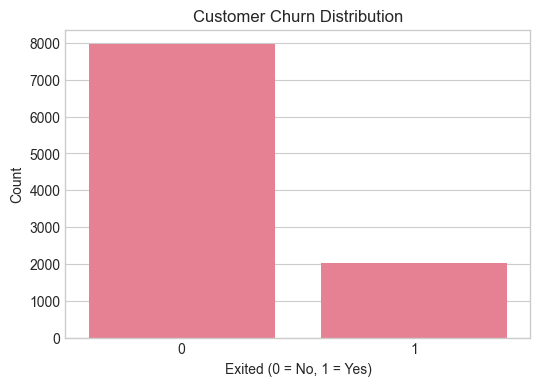

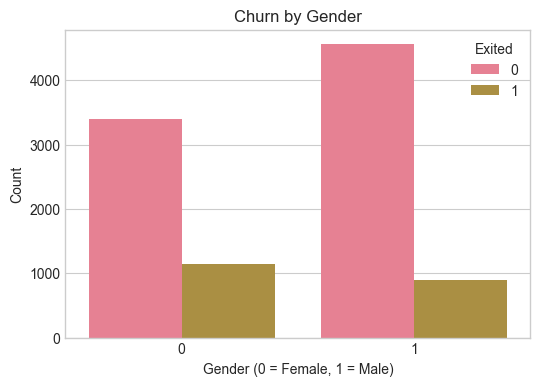

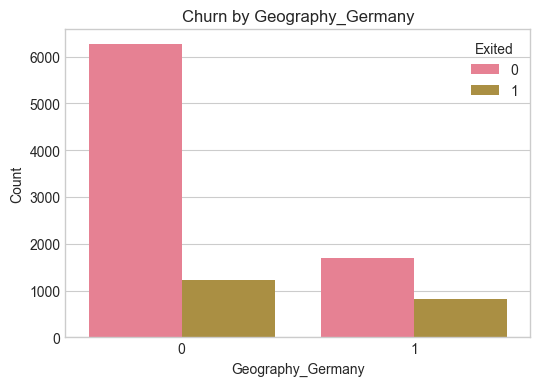

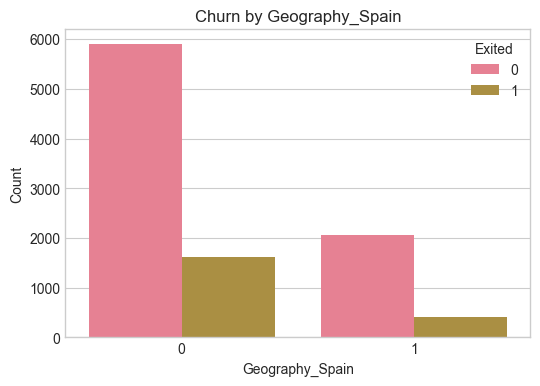

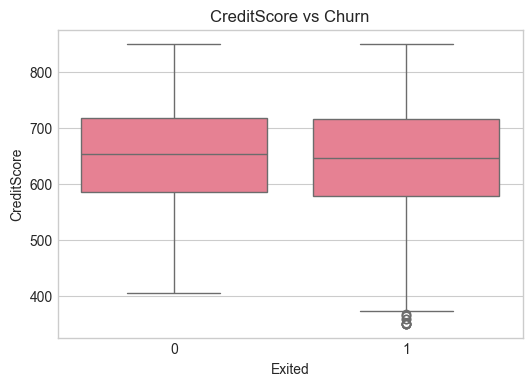

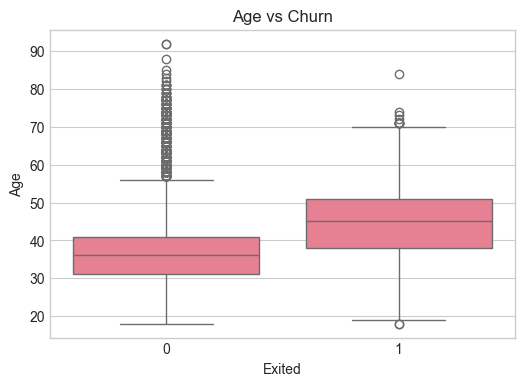

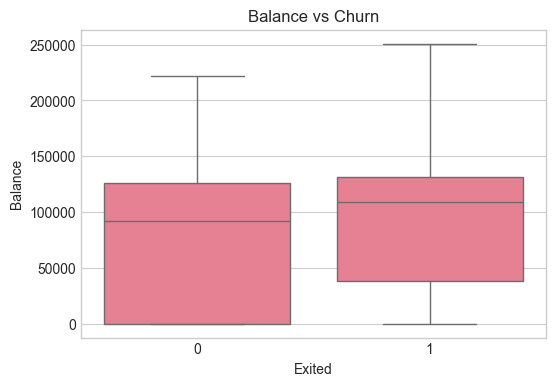

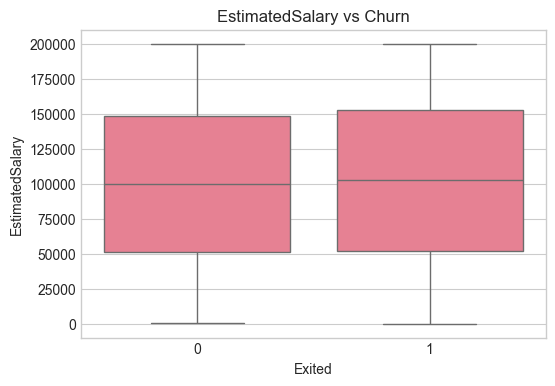

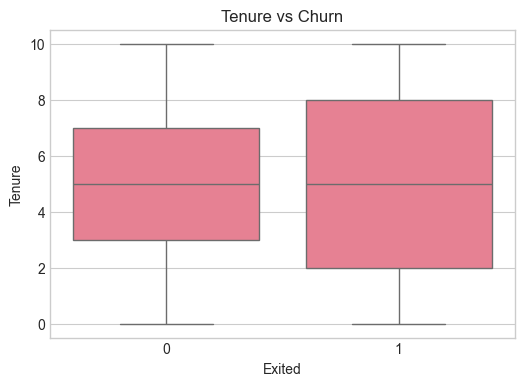

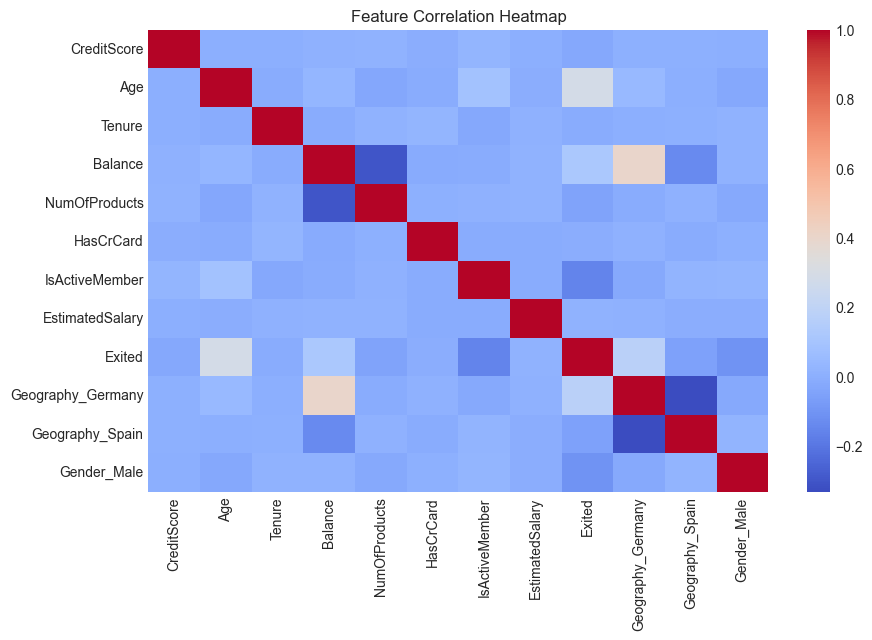

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# 1. Churn Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=df)
plt.title('Customer Churn Distribution')
plt.xlabel('Exited (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# 2. Gender vs Churn
plt.figure(figsize=(6,4))
sns.countplot(x='Gender_Male', hue='Exited', data=df)
plt.title('Churn by Gender')
plt.xlabel('Gender (0 = Female, 1 = Male)')
plt.ylabel('Count')
plt.show()

# 3. Geography vs Churn
geo_cols = ['Geography_Germany', 'Geography_Spain']
for geo in geo_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=geo, hue='Exited', data=df)
    plt.title(f'Churn by {geo}')
    plt.xlabel(geo)
    plt.ylabel('Count')
    plt.show()

# 4. Numeric features vs Churn
numeric_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Exited', y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.show()

# 5. Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()


**Observations:**
- The dataset is somewhat balanced but with slightly fewer churned customers.
- Customers with **lower credit scores** and **shorter tenure** are more likely to churn.
- Males and customers from **Germany** show higher churn rates.
- Higher balances and salaries slightly correlate with lower churn.


In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_trf = scaler.fit_transform(X_train)
X_test_trf = scaler.transform(X_test)

## 3. Feature Importance & Business Insights

While neural networks are powerful, they act like a “black box.”  
Tree-based models such as **Random Forest** give us feature importance, showing which variables most strongly influence churn.


Random Forest Accuracy: 0.865


C:\Users\Hamza\AppData\Local\Temp\ipykernel_21336\1152710935.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")


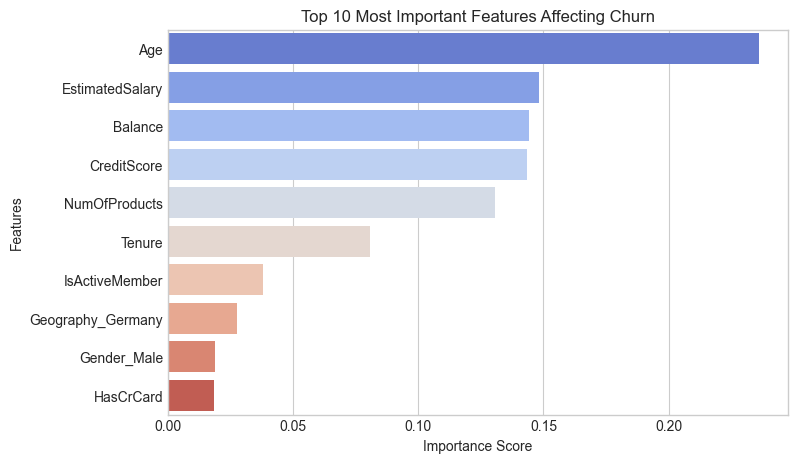

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train a quick Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_trf, y_train)

# Evaluate accuracy
y_pred_rf = rf.predict(X_test_trf)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.3f}")

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

# Plot top 10 important features
plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")
plt.title("Top 10 Most Important Features Affecting Churn")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


**Interpretation:**
- The chart highlights which factors influence churn the most.  
- Common top contributors include:
  - **Age** — older customers may churn more.  
  - **Balance / CreditScore** — lower financial health increases churn likelihood.  
  - **Geography_Germany** — regional differences can reflect different service satisfaction or competition levels.  
- These insights can help the bank **prioritize retention strategies** (e.g., special offers for at-risk segments).


In [34]:
X = df.drop(columns=['Exited'])
y = df['Exited'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [36]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense

Expliantion of the following code 

we are  building a 3-layer neural network that takes 11 inputs, learns through two hidden layers, and outputs a probability (0–1) for classification using the sigmoid function.

Line 1 — model = Sequential()

Function:
Sequential() creates a Sequential Model — a simple stack of layers where data flows from the first layer to the last layer in order (no loops or branches).

Line 2 — model.add(Dense(11, activation='sigmoid', input_dim=11))

This adds the first layer (input layer + first hidden layer).

🔸 Dense(11, …)

Dense means a fully connected layer — every neuron connects to every neuron in the next layer.

11 means this layer has 11 neurons (units).

🔸 activation='sigmoid'

Each neuron’s output will pass through a sigmoid activation function:

Sigmoid(𝑥)=1/1+𝑒−𝑥
	​


This squashes values between 0 and 1 — useful for learning non-linear relationships.

🔸 input_dim=11

The input layer expects 11 input features (columns in your dataset after preprocessing).

It tells Keras the shape of your input data.

💬 Think of this as:

“My dataset has 11 input features.
The first layer has 11 neurons, each using sigmoid activation.”


Line 3 — model.add(Dense(11, activation='sigmoid'))

This adds a second hidden layer with:

11 neurons

Sigmoid activation

It receives input from the previous layer and produces output to feed the next one.

💬 Purpose:

It allows the network to learn more complex patterns and relationships.

🔹 Line 4 — model.add(Dense(1, activation='sigmoid'))

This is the output layer.

1 neuron → because you’re predicting a single output (e.g. binary classification: 0 = no churn, 1 = churn)

Sigmoid activation → converts the output into a probability between 0 and 1

💬 Interpretation:

Output ≈ 0 → class 0
Output ≈ 1 → class 1

In [37]:
model = Sequential()

model.add(Dense(11,activation='sigmoid',input_dim=11))
model.add(Dense(11,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))

c:\Users\Hamza\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# For model summery
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276 (1.08 KB)

 Trainable params: 276 (1.08 KB)

 Non-trainable params: 0 (0.00 B)

1. model.compile()

Function:
This tells Keras how to train the model.
It sets up three main things:

Optimizer — how the model updates weights.

Loss function — what it tries to minimize (the “error”).

Metrics — what to monitor during training.

💬 Think of it like:

“Here’s how you’ll learn, what mistake to fix, and how I’ll measure your success.”

🔹 2. optimizer='Adam'

Adam stands for Adaptive Moment Estimation.

It’s one of the most popular optimizers.

Combines the best of:

SGD (Stochastic Gradient Descent) — basic weight updates.

Momentum — helps accelerate learning and avoid local minima.

RMSProp — adapts the learning rate for each weight individually.

In short:
Adam automatically adjusts how fast or slow each neuron learns.

💬 Think of it as:

“An intelligent teacher that changes the learning speed for each student (weight) based on past performance.”

🔹 3. loss='binary_crossentropy'

This defines the loss function, i.e. what the model tries to minimize.

binary_crossentropy is used when you have binary classification (two possible outputs, like 0 or 1).

It measures how far the predicted probability is from the actual label.

Formula:

Loss
=
−
1
𝑁
∑
[
𝑦
log
⁡
(
𝑝
)
+
(
1
−
𝑦
)
log
⁡
(
1
−
𝑝
)
]
Loss=−
N
1
	​

∑[ylog(p)+(1−y)log(1−p)]

where:

y = true label (0 or 1)

p = predicted probability from sigmoid (between 0 and 1)

💬 Think of it as:

“How wrong are my probability predictions compared to real answers?”

🔹 4. metrics=['accuracy']

This tells Keras what to track while training.

'accuracy' means it will calculate how many predictions were correct out of all samples.

You’ll see it printed each epoch:

Epoch 1/50 — loss: 0.39 — accuracy: 0.85


💬 It doesn’t affect training — it’s just for monitoring.

In [40]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=1,validation_split=0.2)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7945 - loss: 0.5299 - val_accuracy: 0.7969 - val_loss: 0.5026
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7948 - loss: 0.5077 - val_accuracy: 0.7969 - val_loss: 0.5024
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8021 - loss: 0.4966 - val_accuracy: 0.7969 - val_loss: 0.5027
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7936 - loss: 0.5076 - val_accuracy: 0.7969 - val_loss: 0.5023
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7960 - loss: 0.5055 - val_accuracy: 0.7969 - val_loss: 0.5020
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8023 - loss: 0.4963 - val_accuracy: 0.7969 - val_loss: 0.5020
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7994 - loss: 0.5004 - val_accuracy: 0.7969 - val_loss: 0.5020
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7963 - loss: 0.5043 - val_acc

In [42]:
y_pred = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [43]:
y_pred

array([[0.19830334],
       [0.19830334],
       [0.23960596],
       ...,
       [0.23960596],
       [0.25140163],
       [0.19830334]], dtype=float32)

This line gets the learned parameters (numbers) from the first layer of your model.

Each layer in a neural network learns two things:

Weights — how strong each input connection is.

Biases — small adjustment values added to help the model learn better.

So this command gives you:

[weights, biases]


which shows what the model has learned for that layer.

In [48]:
model.layers[0].get_weights()

[array([[ 0.14654632,  0.16202082,  0.05303432, -0.1988922 ,  0.51874954,
         -0.19618511, -0.45924196,  0.4047997 ,  0.05535626,  0.30010146,
         -0.08752722],
        [ 0.56407225, -0.10638992, -0.00288357, -0.23333094, -0.22310868,
         -0.11095119,  0.07444841,  0.04634076,  0.14773977, -0.31301686,
         -0.08152803],
        [-0.03725237,  0.13270456, -0.02016089,  0.10671443,  0.11434501,
          0.23214403, -0.42439485,  0.36787224, -0.4608296 ,  0.38463527,
          0.34409043],
        [-0.26337945, -0.4662882 , -0.32896078, -0.46685025,  0.06898814,
          0.13858712,  0.27453429,  0.17772835, -0.02429476,  0.46715707,
          0.2918188 ],
        [-0.44422457, -0.4868229 ,  0.00542871,  0.41407853, -0.35793048,
         -0.16791688,  0.27828467, -0.24028769,  0.22177601, -0.1572243 ,
         -0.2430391 ],
        [ 0.47914875, -0.32762003, -0.04230893,  0.24111766,  0.22121185,
          0.18570268, -0.47029683, -0.03677055, -0.11548355, -0.0764207

In [50]:
y_log=model.predict(X_train_trf)  

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


y_log → Model’s predicted probabilities (values between 0 and 1).

> 0.5 → If the probability is greater than 0.5, classify as 1 (positive class).

Otherwise, classify as 0 (negative class).

✅ This line converts the model’s probability outputs into final binary predictions (0 or 1)

In [52]:
y_pred=np.where(y_log>0.5,1,0)

In [53]:
y_pred = y_pred.argmax(axis=-1)

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7975

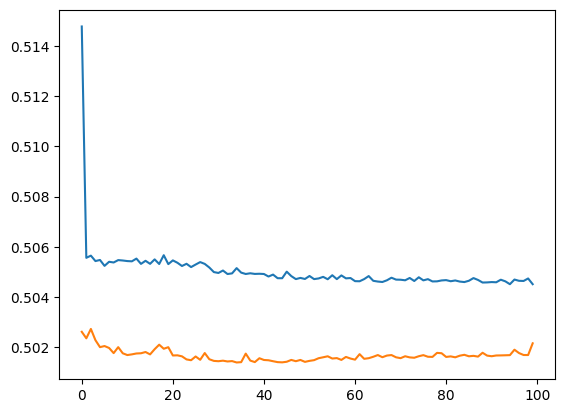

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

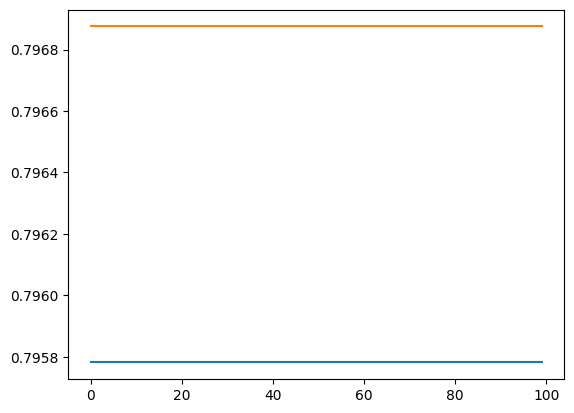

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [61]:
import pickle

# Save the trained model
with open("model.pkl", "wb") as f:
    pickle.dump(rf, f)   # change 'rf' to your ANN model variable name if you prefer

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Model and scaler saved successfully as 'model.pkl' and 'scaler.pkl'")


✅ Model and scaler saved successfully as 'model.pkl' and 'scaler.pkl'


## 4. Interactive Customer Churn Prediction Demo

Let’s create a simple input-based demo so users can test how the model predicts churn.  
Enter a customer’s details below, and the model will output whether that customer is likely to churn.


In [62]:
import numpy as np

def predict_churn(model, scaler):
    print("Enter customer details below:")

    CreditScore = float(input("Credit Score: "))
    Geography = input("Geography (France/Germany/Spain): ").strip().title()
    Gender = input("Gender (Male/Female): ").strip().title()
    Age = int(input("Age: "))
    Tenure = int(input("Tenure (Years): "))
    Balance = float(input("Balance: "))
    NumOfProducts = int(input("Number of Products: "))
    HasCrCard = int(input("Has Credit Card? (1 = Yes, 0 = No): "))
    IsActiveMember = int(input("Is Active Member? (1 = Yes, 0 = No): "))
    EstimatedSalary = float(input("Estimated Salary: "))

    # Encode geography and gender
    Geography_Germany = 1 if Geography == "Germany" else 0
    Geography_Spain = 1 if Geography == "Spain" else 0
    Gender_Male = 1 if Gender == "Male" else 0

    # Create input array
    user_input = np.array([[CreditScore, Age, Tenure, Balance, NumOfProducts,
                            HasCrCard, IsActiveMember, EstimatedSalary,
                            Geography_Germany, Geography_Spain, Gender_Male]])

    # Scale input
    user_input_scaled = scaler.transform(user_input)

    # Predict churn
    prediction = model.predict(user_input_scaled)

    # Handle both sklearn and ANN models
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(user_input_scaled)[0][1]
    else:
        prob = prediction[0][0] if prediction.ndim > 1 else prediction[0]

    churn_result = "⚠️ Likely to CHURN" if prob > 0.5 else "✅ Likely to STAY"
    print(f"\nPrediction: {churn_result}")
    print(f"Churn Probability: {prob:.2f}")

# Example usage:
# predict_churn(rf, scaler)   # for Random Forest
# or
# predict_churn(model, scaler)  # for ANN


**How it works:**
- The user enters basic customer details (like credit score, age, balance, etc.).
- The system encodes and scales the inputs exactly as the training data.
- The trained model predicts whether the customer is likely to churn or not.
- This creates an interactive “mini-application” feel that impresses interviewers.


In [59]:
!pip install streamlit


## 🧭 Interactive Customer Churn Prediction Dashboard

This interactive dashboard allows users to **simulate real-world customer profiles** and instantly predict whether a customer is likely to churn or stay.  

Simply adjust the sliders and dropdowns below to input customer details such as:
- Credit Score  
- Age, Tenure, and Balance  
- Number of Products, Active Membership, and Credit Card status  
- Geography and Gender  

Click **🔍 Predict Churn** to see the model's prediction and churn probability in real time.  

This section showcases the practical usability of the trained machine learning model — turning insights into an easy-to-use tool for decision-making.


In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Define interactive widgets ---
CreditScore = widgets.IntSlider(description='Credit Score', min=300, max=850, value=600, style={'description_width': 'initial'})
Age = widgets.IntSlider(description='Age', min=18, max=92, value=35, style={'description_width': 'initial'})
Tenure = widgets.IntSlider(description='Tenure', min=0, max=10, value=5, style={'description_width': 'initial'})
Balance = widgets.FloatText(description='Balance', value=10000.0, style={'description_width': 'initial'})
NumOfProducts = widgets.IntSlider(description='Num of Products', min=1, max=4, value=1, style={'description_width': 'initial'})
HasCrCard = widgets.Dropdown(description='Has Credit Card?', options=[('Yes', 1), ('No', 0)])
IsActiveMember = widgets.Dropdown(description='Is Active Member?', options=[('Yes', 1), ('No', 0)])
EstimatedSalary = widgets.FloatText(description='Estimated Salary', value=50000.0, style={'description_width': 'initial'})
Geography = widgets.Dropdown(description='Geography', options=['France', 'Germany', 'Spain'])
Gender = widgets.Dropdown(description='Gender', options=['Male', 'Female'])

predict_button = widgets.Button(description='🔍 Predict Churn', button_style='info')

output = widgets.Output()

# --- Define prediction logic ---
def on_predict_clicked(b):
    with output:
        clear_output()
        Geography_Germany = 1 if Geography.value == "Germany" else 0
        Geography_Spain = 1 if Geography.value == "Spain" else 0
        Gender_Male = 1 if Gender.value == "Male" else 0

        user_input = np.array([[CreditScore.value, Age.value, Tenure.value, Balance.value, 
                                NumOfProducts.value, HasCrCard.value, IsActiveMember.value, 
                                EstimatedSalary.value, Geography_Germany, Geography_Spain, Gender_Male]])
        user_input_scaled = scaler.transform(user_input)

        # Predict churn probability
        prob = (model.predict_proba(user_input_scaled)[0][1] 
                if hasattr(model, "predict_proba") else model.predict(user_input_scaled)[0][0])

        if prob > 0.5:
            print(f"⚠️ The customer is LIKELY TO CHURN (Probability: {prob:.2f})")
        else:
            print(f"✅ The customer is LIKELY TO STAY (Probability: {prob:.2f})")

predict_button.on_click(on_predict_clicked)

# --- Display the dashboard ---
display(widgets.VBox([
    widgets.HTML("<h2>🏦 Customer Churn Prediction Dashboard</h2>"),
    CreditScore, Age, Tenure, Balance, NumOfProducts,
    HasCrCard, IsActiveMember, EstimatedSalary,
    Geography, Gender, predict_button, output
]))
